## Taxis Dataset Analysis, PPCA + GMM
___

In [1]:
import matplotlib.pyplot as plt

from advi import *
from advi_models import *

**loading data :**

In [7]:
data = pd.read_csv('Data/interp_taxis_df.csv')

X = data.iloc[:5000,:].to_numpy()

data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,y41,y42,y43,y44,y45,y46,y47,y48,y49,y50
0,-8.612145,-8.612134,-8.612223,-8.612532,-8.612801,-8.613046,-8.613043,-8.613072,-8.613258,-8.613715,...,41.157026,41.156311,41.156119,41.156069,41.156064,41.156064,41.156060,41.156049,41.156039,41.156028
1,-8.606979,-8.607039,-8.607198,-8.607731,-8.607784,-8.607565,-8.606649,-8.605264,-8.604333,-8.604351,...,41.128113,41.125798,41.124393,41.122211,41.120273,41.120069,41.119872,41.118261,41.116904,41.116626
2,-8.610966,-8.610454,-8.610069,-8.609403,-8.609149,-8.610050,-8.612146,-8.620671,-8.623431,-8.624752,...,41.150607,41.150597,41.150705,41.151157,41.152270,41.153323,41.154262,41.155045,41.155438,41.154813
3,-8.628435,-8.628425,-8.628395,-8.628308,-8.628220,-8.628133,-8.628084,-8.628048,-8.627616,-8.627147,...,41.162637,41.162638,41.162643,41.162658,41.162667,41.162657,41.162644,41.162629,41.162621,41.162616
4,-8.589447,-8.589453,-8.589460,-8.589468,-8.589480,-8.589473,-8.589416,-8.589294,-8.588715,-8.587755,...,41.148765,41.148765,41.148765,41.148771,41.148778,41.148784,41.148791,41.148797,41.148858,41.148999


___
### I. Probabilistic Principal Component Analysis with Automatic Relevant Determination using Automatic Differentiation Variational Inference

In [8]:
latent_dim = 100
mc_size = 2
n_iter = 500

In [129]:
ppca_ard = PPCA_ARD(Xtest, latent_dim)

advi = ADVI(ppca_ard, lr=0.5, mc_size=1, max_iter=300)

elbos = advi.fit(Xtest)

100%|██████████| 300/300 [00:04<00:00, 69.29it/s]


In [130]:
max(advi.elbo_history())

-917187.5625

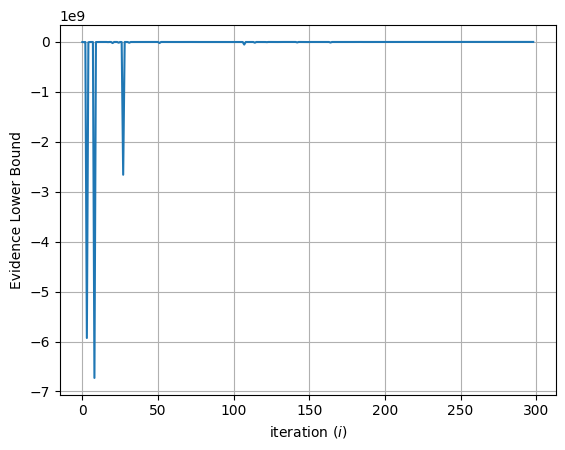

In [131]:
plt.plot(advi.elbo_history()[1:])
plt.grid()

plt.ylabel('Evidence Lower Bound')
plt.xlabel('iteration $(i)$')
plt.savefig(f'figs/ppca_ard_elbo_mc{mc_size}.png')

**Estimates for $\theta = (w, z, \sigma, \alpha)$ :** 

In [151]:
w, z, sigma, alpha = advi.theta_estimates()

**Estimates for the sampling distribution $\phi=(\mu, \omega)$ :**

In [152]:
mu, omega = advi.phi_estimates()

**Plotting variability importance values and subspace projection :**

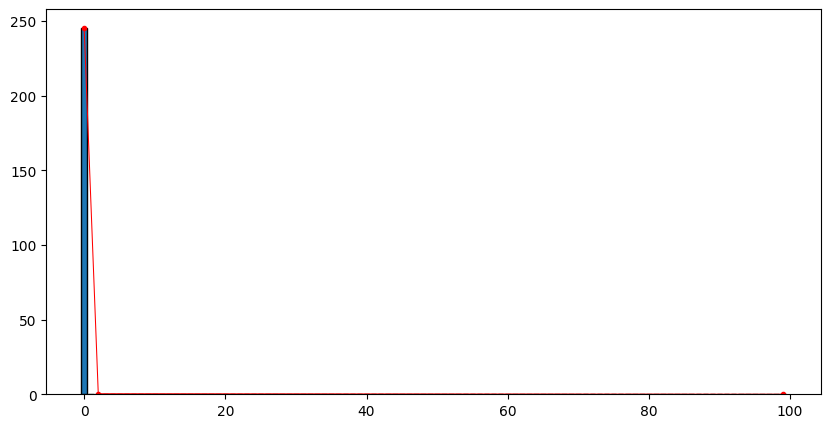

In [153]:
dim_selection = 2

sorted_alpha, sorted_idxs = torch.sort(alpha.squeeze(), descending=True)
idxs = range(len(sorted_alpha))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.bar(idxs,sorted_alpha, edgecolor='black')
sub_pts = [0, dim_selection, 99]
ax.plot(sub_pts, [sorted_alpha[i] for i in sub_pts],  marker='.', color='red', linewidth=0.75)

In [154]:
sorted_idxs

tensor([91, 12, 85, 19, 80, 64, 90, 37, 44,  3, 77, 84, 86, 95, 71,  0, 22, 73,
        23, 63, 28, 17, 60, 57, 70, 87,  8, 15, 20, 21,  5, 89,  7, 36, 54, 96,
        81, 40, 34, 29, 66, 56, 13, 61, 94, 62, 49, 98, 32, 74, 76, 58, 41, 47,
        38, 39, 69, 46, 31, 11, 52, 24, 97, 93, 30, 25,  9, 48, 68, 88, 50, 16,
        92, 82,  6,  2, 79, 59, 83, 53, 14, 67, 75, 10, 42, 26, 18, 33,  1, 51,
        65,  4, 99, 55, 43, 78, 27, 35, 45, 72])

In [155]:
from sklearn.decomposition import PCA

In [156]:
dim_selection = 2
sorted_alpha, sorted_idxs = torch.sort(alpha.squeeze(), descending=True)
Xppca = pd.DataFrame(z[:,sorted_idxs[:dim_selection]])
Xppca

# pca = PCA(n_components=11)
# Xppca = pca.fit_transform(X)

,0,1
0,-0.779161,0.426434
1,0.342728,0.318591
2,-1.256900,1.663139
3,-0.059385,-0.402940
4,0.158052,-0.614037
...,...,...
2995,0.459424,-0.401875
2996,-0.043704,-0.240942
2997,0.188757,0.754607
2998,-1.390803,0.305360


___
### II. Gaussian Mixture Model for trajectories clustering

In [157]:
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from matplotlib.colors import ListedColormap

In [158]:
cmap = ListedColormap(['blue', 'red'])
cmap.colors

['blue', 'red']

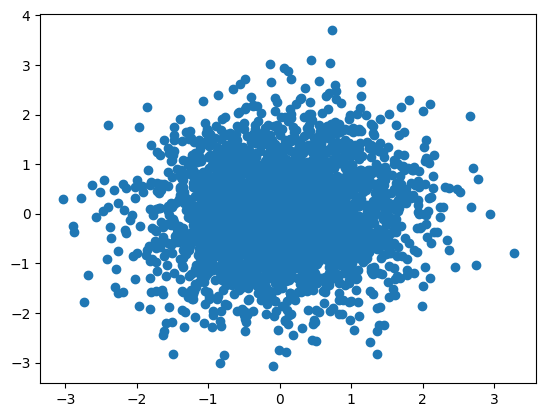

In [160]:
plt.scatter(Xppca.iloc[:,0], Xppca.iloc[:,1])
#plt.scatter(z[:,65], z[:,35])

In [39]:
gmm = GaussianMixture(n_components=2, max_iter=100)

pred = gmm.fit_predict(Xppca)

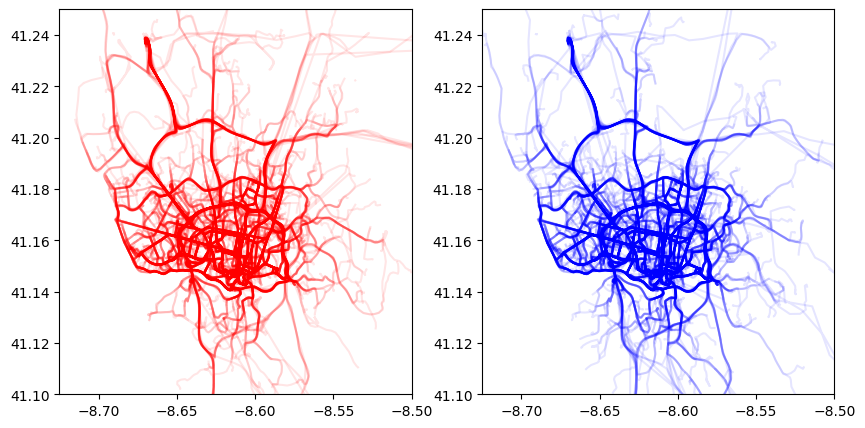

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sub_df = data.iloc[:5000,:]
sub = sub_df.loc[pred == 0]
xp = sub.iloc[:,:50].to_numpy()
yp = sub.iloc[:,50:100].to_numpy()
for i in range(len(sub)):
    axs[0].plot(xp[i], yp[i], color='red', alpha=0.1)

sub = sub_df.loc[pred == 1]
xp = sub.iloc[:,:50].to_numpy()
yp = sub.iloc[:,50:100].to_numpy()
for i in range(len(sub)):
    axs[1].plot(xp[i], yp[i], color='blue', alpha=0.1)

axs[0].set_ylim(41.1, 41.25)
axs[1].set_ylim(41.1, 41.25)

axs[0].set_xlim(-8.725, -8.5)
axs[1].set_xlim(-8.725, -8.5)

plt.show()